<a href="https://colab.research.google.com/github/PasechnikDarya/RAAI-NLP-Project/blob/main/topic_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Загрузка данных

In [32]:
import torch
import itertools
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid", font_scale=1.4)

In [33]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [34]:
data = pd.read_csv('/content/drive/MyDrive/blogtext.csv')

In [35]:
data.head()

,id,gender,age,topic,sign,date,text
0,2059027,male,15,Student,Leo,"14,May,2004","Info has been found (+/- 100 pages,..."
1,2059027,male,15,Student,Leo,"13,May,2004",These are the team members: Drewe...
2,2059027,male,15,Student,Leo,"12,May,2004",In het kader van kernfusie op aarde...
3,2059027,male,15,Student,Leo,"12,May,2004",testing!!! testing!!!
4,3581210,male,33,InvestmentBanking,Aquarius,"11,June,2004",Thanks to Yahoo!'s Toolbar I can ...


In [36]:
data['text'][456]

"              Frustration  I'm so frustrated! At the lack of productivity. At the hunger pangs caused by waiting...waiting...waiting...  I'm meant BE at Soony and Michy's for dinner right now, yet am stuck waiting for my ride to come, who's in turn, stuck at a meeting which should have been settled eons ago. The complications of starting a new business. Sheesh...  Ah wells. Yuli is heading down now to hand me some forms for data entry. Yippee. Am finally  doing  something...           "

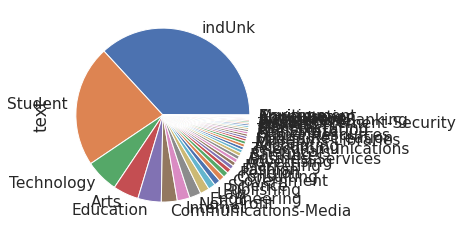

In [37]:
data.groupby('topic').count()[['text']].sort_values(['text'], ascending=False)['text'].plot.pie()

In [38]:
NUM_CLASSES = 5

data = data[data['topic'] != 'indUnk']
classes = data.groupby('topic', as_index=False).count()[['text', 'topic']].sort_values(['text'], ascending=False)['topic'].values[:NUM_CLASSES]

data = data[data['topic'].isin(classes)].reset_index(drop=True)

In [39]:
frequencies = data.groupby('topic').count()[['text']].sort_values(['text'], ascending=False)['text'].values / data.shape[0]
frequencies

array([0.55324969, 0.15117909, 0.11664749, 0.10652455, 0.07239917])

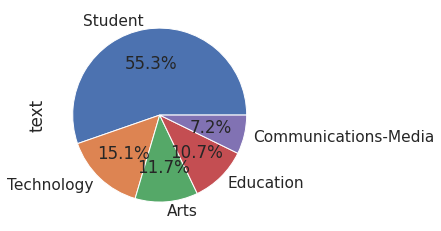

In [40]:
data.groupby('topic').count()[['text']].sort_values(['text'], ascending=False)['text'].plot.pie(autopct="%.1f%%")

In [41]:
# for balanced data

# one_class_size = data[data['topic'] == classes[-1]].shape[0]

# prepr_data = pd.concat([data[data['topic'] == x][:one_class_size] for x in classes], axis=0)

# old_data = data
# data = prepr_data.reset_index(drop=True)

In [42]:
CUT = data.shape[0] #100000

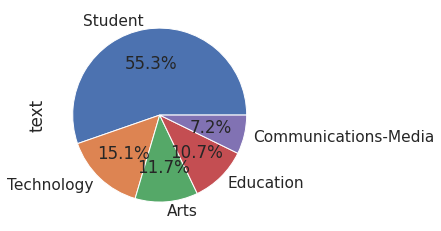

In [43]:
data.loc[:CUT, :].groupby('topic').count()[['text']].sort_values(['text'], ascending=False)['text'].plot.pie(autopct="%.1f%%")

In [44]:
label2idx = {label: i for i, label in enumerate(data['topic'].unique())}
idx2label = {i: label for i, label in enumerate(data['topic'].unique())}

In [45]:
for i in idx2label.keys():
  if label2idx[idx2label[i]] != i:
    print('aaa')

In [46]:
from sklearn.model_selection import train_test_split

train_indexes, test_indexes = train_test_split(data.index[:CUT], test_size=0.2, stratify=data['topic'][:CUT], shuffle=True)

In [47]:
 class Dataset:

    def __init__(self, data, labels, vocab=None):
        self.vocab = vocab
        self.data = data
        self.tokenised = None
        self.labels = [label2idx[label] for label in labels]

    def __getitem__(self, index):
        answer = {"input": self.tokenised[index]}
        if self.labels is not None:
            answer["label"] = self.labels[index]
        return answer

    def __len__(self):
        return len(self.data)
    
    def cut_to_fixed_size(self, max_size=512):
        self.tokenised = [text[:max_size] for text in tqdm(self.tokenised)]

    def drop_too_short(self, min_size=1):
      self.labels = [label for idx, label in tqdm(enumerate(self.labels)) if len(self.tokenised[idx]) > min_size]
      self.data = [text for idx, text in tqdm(enumerate(self.data)) if len(self.tokenised[idx]) > min_size]
      self.tokenised = [text for text in tqdm(self.tokenised) if len(text) > min_size]


In [48]:
train_dataset = Dataset(list(data['text'].values[train_indexes]), list(data['topic'].values[train_indexes]))
test_dataset = Dataset(list(data['text'].values[test_indexes]), list(data['topic'].values[test_indexes]))

In [49]:
import nltk

nltk.download('stopwords')
from nltk.tokenize import wordpunct_tokenize
from nltk.corpus import stopwords as nltk_stopwords

nltk_stopwords = nltk_stopwords.words("english")

def is_word(word):
    word = word.lower()
    return all(x.isalpha() or x.isdigit() or x == "-" for x in word) and any(x.isalpha() or x.isdigit() for x in word)

def process_text(text, to_lower=True, only_alpha=True, remove_stopwords=False):
    words = wordpunct_tokenize(text) if isinstance(text, str) else text
    if to_lower:
        words = [word.lower() for word in words]
    if only_alpha:
        words = [word for word in words if is_word(word)]
    if remove_stopwords:
        words = [word for word in words if word not in nltk_stopwords]
    return words

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
train_dataset.tokenised = [process_text(text, remove_stopwords=True) for text in tqdm(train_dataset.data)]
test_dataset.tokenised = [process_text(text, remove_stopwords=True) for text in tqdm(test_dataset.data)]

In [54]:
class Vocabulary:

    def __init__(self, vocab=None):
        self.vocab = vocab

    def encode(self, data):
        if isinstance(data, list) and len(data) > 0 and not isinstance(data[0], str):
            return [self.encode(text) for text in data]
        # data --- это отдельный текст
        indexes = [self.vocab.get(token, self.vocab['unk']) for token in data]
        return indexes

In [52]:
import gensim.downloader as api
glove_model = api.load("glove-twitter-50")

In [53]:
glove_word2idx = {word: idx for idx, word in enumerate(glove_model.index2word)}

glove_vocab = Vocabulary()
glove_vocab.vocab = glove_word2idx
# dataset.vocab = glove_vocab

In [ ]:
train_dataset.tokenised = glove_vocab.encode(train_dataset.tokenised)
test_dataset.tokenised = glove_vocab.encode(test_dataset.tokenised)

In [ ]:
train_dataset.cut_to_fixed_size(128)
test_dataset.cut_to_fixed_size(128)

In [ ]:
train_dataset.drop_too_short()
test_dataset.drop_too_short()

In [ ]:
len(test_dataset.labels), len(test_dataset.tokenised)

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

def pad_tensor(vec, length, dim, pad_symbol):
    pad_size = list(vec.shape)
    pad_size[dim] = length - vec.shape[dim]
    answer = torch.cat([vec, torch.ones(*pad_size, dtype=vec.dtype) * pad_symbol], axis=dim)
    return answer

def pad_tensors(tensors, dim=0, pad=0):
    # дополняет тензоры из tensors до общей максимальной длины символом pad
    if isinstance(tensors[0], (int, np.integer)):
        # массив целых чисел
        return torch.LongTensor(tensors)
    elif isinstance(tensors[0], (float, np.float)):
        # массив действительных чисел
        return torch.Tensor(tensors)
    if not isinstance(tensors[0], torch.Tensor):
        # приводим к массивам, чтобы можно было определить тип
        tensors = [np.array(tensor) for tensor in tensors]
        if np.issubdtype(tensors[0].dtype, np.integer):
            tensors = [torch.LongTensor(tensor) for tensor in tensors]
        else:
            tensors = [torch.Tensor(tensor) for tensor in tensors]
    L = max(tensor.shape[0] for tensor in tensors)
    tensors = [pad_tensor(tensor, L, dim=dim, pad_symbol=pad) for tensor in tensors]
    return torch.stack(tensors, dim=0)


class BatchDataLoader(DataLoader):

    def __init__(self, data, batch_size: int=32, pad=0, device="cpu", sort_field="input"):
        self.data = data
        self.batch_size = batch_size
        self.pad = pad
        self.device = device
        self.sort_field = sort_field

    def __iter__(self):
        self.order = np.argsort([len(elem[self.sort_field]) for elem in self.data])[::-1]
        self.idx = 0
        return self

    def __len__(self):
        return (len(self.data)-1) // self.batch_size + 1

    def __next__(self):
        if self.idx >= len(self.data):
            raise StopIteration()
        end = min(self.idx + self.batch_size, len(self.data))
        indexes = self.order[self.idx:end]
        # print(self.idx, end, indexes)
        answer = dict()
        for field in self.data[indexes[0]]:
            # записываем тензоры для всех полей
            answer[field] = pad_tensors([self.data[i][field] for i in indexes]).to(self.device)
        # записываем индексы всех объектов
        answer["indexes"] = indexes
        self.idx = end
        return answer

In [ ]:
class LSTMModel(nn.Module):
    def __init__(self, num_classes, embed_size, vocab_size, hidden_size=128, mean=False):
        super().__init__()
        self.mean = mean
        self.n_hidden = hidden_size
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, bidirectional=True, batch_first=True)
        self.cls = nn.Linear(hidden_size * 2, num_classes)

    def forward(self, x):
        x = self.embedding(x)
        lstm_outputs, states = self.lstm(x)
        state = states[0]
        if self.mean:
            state = torch.mean(lstm_outputs, dim=1)
        else:
            # state.shape = (B, 2, H)
            state = state.permute((1, 0, 2))
            # state.shape = (B, 2*H)
            state = state.reshape(-1, 2*self.n_hidden)

        output = self.cls(state)
        # print(hidden.shape)
        # output = self.ac(hidden)
        return output

In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

In [57]:
def freeze_embeddings(model, req_grad=False):
    embeddings = model.embedding
    for c_p in embeddings.parameters():
        c_p.requires_grad = req_grad

def measure_quality(y_test, y_pred):
    accuracy = accuracy_score(y_test, y_pred)
    print("accuracy: {:.2f}".format(accuracy))
    precision, recall, f_score, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')
    print("precision: {:.2f}".format(precision))
    print("recall: {:.2f}".format(recall))
    print("F1-score: {:.2f}".format(f_score))
    return {"accuracy": accuracy, "precision": precision, "recall": recall, "F1": f_score}

In [131]:
from tqdm.notebook import tqdm, trange

def training_freeze(model, criterion, optimizer, num_epochs, loaders, max_grad_norm=2, num_freeze_iter=1000):
    history = {
        'train_loss':[],
        'val_loss':[],
    }

    unfreeze_flg = False
    freeze_embeddings(model)
    for e in trange(num_epochs, leave=False):
        model.train()
        num_iter = 0
        
        train_loss = 0

        pbar = tqdm(loaders["train"], leave=False)
        for batch in pbar:

            if not unfreeze_flg and num_iter > num_freeze_iter:
                freeze_embeddings(model, True)
                unfreeze_flg = True
                
            optimizer.zero_grad()

            input_embeds = batch["input"].to(device)
            labels = batch["label"].to(device)

            prediction = model(input_embeds)
            loss = criterion(prediction, labels)
            train_loss += loss

            if num_iter % 1000 == 0:
                print('train loss: ', loss.item())
                print('train: ', (prediction.argmax(-1) == labels).float().sum().item())

            loss.backward()

            if max_grad_norm is not None:
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
            optimizer.step()
            num_iter += 1
        
        history['train_loss'].append(train_loss / num_iter)

        valid_loss = 0
        val_labels = torch.Tensor().to(device)
        val_predictions = torch.Tensor().to(device)
        num_iter = 0
        model.eval()
        with torch.no_grad():
            correct = 0
            num_objs = 0
            for batch in loaders["test"]:
                input_embeds = batch["input"].to(device)
                labels = batch["label"].to(device)
                prediction = model(input_embeds)
                valid_loss += criterion(prediction, labels)
                
                val_labels += labels
                val_predictions += (prediction.argmax(-1) == labels).float()

                num_objs += len(labels)
                num_iter += 1

            print('valid: ', (prediction.argmax(-1) == labels).float().sum().item())

            val_labels = val_labels.cpu().numpy()
            val_prediction = val_prediction.cpu().numpy()

        history['val_loss'].append(valid_loss / num_iter)

        measure_quality(val_labels, val_prediction)
        print(f"\n\tValid Loss: {valid_loss / num_iter}\n\t")

    return history

In [132]:
import torch
del loaders, model
torch.cuda.empty_cache()
import gc
gc.collect()

381

In [133]:
label2idx

{'Arts': 3,
 'Communications-Media': 2,
 'Education': 1,
 'Student': 0,
 'Technology': 4}

In [134]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = LSTMModel(len(label2idx), embed_size=glove_model.vector_size, vocab_size=len(glove_vocab.vocab)).to(device)
criterion = nn.CrossEntropyLoss(weight=torch.Tensor(1 / frequencies).to(device))
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 5
max_grad_norm = 1.0

In [135]:
model.embedding.weight[0]

tensor([ 1.7275e+00, -1.0935e+00, -8.5801e-01, -1.6062e+00,  2.8602e-01,
        -7.5367e-01,  1.7193e-01, -3.9689e-01,  4.5207e-01, -1.1283e+00,
         1.1847e+00,  9.5198e-01,  1.7483e-01,  1.1119e+00, -7.4877e-01,
        -9.0236e-01, -4.9807e-01,  7.1927e-01,  3.2716e+00,  9.4410e-01,
        -1.6434e+00,  1.4374e+00, -9.8839e-03,  1.0054e-03,  2.8803e-01,
        -1.4373e+00, -8.2954e-01,  6.7401e-01, -2.4196e+00, -2.4880e+00,
         1.3212e+00, -1.4693e+00,  2.4021e-01, -4.5762e-01, -1.6938e-01,
        -8.4010e-01, -7.4380e-01,  2.2666e-01, -1.1971e+00, -4.8277e-01,
        -1.1422e+00,  7.3902e-01, -1.1688e+00,  1.0938e+00, -4.5162e-01,
         2.6402e-01,  8.5546e-01, -1.5211e+00, -4.2945e-01, -1.0769e+00],
       device='cuda:0', grad_fn=<SelectBackward>)

In [136]:
with torch.no_grad():
    for word, idx in glove_vocab.vocab.items():
        if word in glove_model:
            model.embedding.weight[idx] = torch.from_numpy(glove_model.get_vector(word))

In [137]:
model.embedding.weight[0]

tensor([ 0.7870,  0.7215,  0.2915, -0.0565,  0.3168,  0.4717,  0.0235,  0.6957,
         0.2078,  0.6098, -0.2239,  0.7481, -2.6208,  0.2012, -0.4810,  0.1290,
         0.0352, -0.2449, -0.3609,  0.0267,  0.2898, -0.1070, -0.3462,  0.0211,
         0.5451, -1.0958, -0.2740,  0.2233,  1.0827, -0.0290, -0.8403,  0.5862,
        -0.3651,  0.3402,  0.8961,  0.3276,  0.2427,  0.6840, -0.3437,  0.1358,
        -2.2162, -0.4254,  0.4616,  0.8863, -0.2201,  0.0256, -0.3862,  0.0801,
        -0.0753, -0.6146], device='cuda:0', grad_fn=<SelectBackward>)

In [138]:
loaders = {'train': BatchDataLoader(train_dataset, device="cuda:0", batch_size=30),
           'test': BatchDataLoader(test_dataset, device="cuda:0", batch_size=30)}

In [139]:
history = training_freeze(model, criterion, optimizer, num_epochs, loaders, max_grad_norm)

train loss:  1.6042441129684448
train:  2.0
train loss:  1.5521960258483887
train:  12.0
train loss:  1.4964659214019775
train:  9.0
train loss:  1.2897944450378418
train:  8.0
train loss:  1.6408601999282837
train:  14.0
train loss:  1.5238856077194214
train:  12.0
train loss:  1.4147062301635742
train:  11.0
train loss:  1.1068658828735352
train:  11.0
valid:  13344.0

Valid Loss: 1.5671137571334839, accuracy: 0.2427903413772583


train loss:  2.0938007831573486
train:  4.0
train loss:  1.3576079607009888
train:  14.0
train loss:  1.3406767845153809
train:  15.0
train loss:  0.8552471399307251
train:  17.0
train loss:  1.2725225687026978
train:  20.0
train loss:  1.340220332145691
train:  16.0
train loss:  1.204927921295166
train:  13.0
train loss:  1.005373477935791
train:  13.0
valid:  19042.0

Valid Loss: 1.5379021167755127, accuracy: 0.3464638590812683


train loss:  1.8751527070999146
train:  11.0
train loss:  0.9955369830131531
train:  17.0
train loss:  1.3692245483398438
train:  15.0
train loss:  0.6504907011985779
train:  21.0
train loss:  0.9358469843864441
train:  23.0
train loss:  1.1336417198181152
train:  18.0
train loss:  1.0995558500289917
train:  15.0
train loss:  0.8795000314712524
train:  14.0
valid:  22712.0

Valid Loss: 1.518717646598816, accuracy: 0.4132384657859802


train loss:  1.202728033065796
train:  15.0
train loss:  0.7384135127067566
train:  20.0
train loss:  1.2524420022964478
train:  16.0
train loss:  0.46550747752189636
train:  22.0
train loss:  0.6866809725761414
train:  24.0
train loss:  0.9660117030143738
train:  20.0
train loss:  0.9007287621498108
train:  17.0
train loss:  0.728470504283905
train:  18.0
valid:  24061.0

Valid Loss: 1.5693219900131226, accuracy: 0.4377831518650055


train loss:  0.7392320036888123
train:  19.0
train loss:  0.4482228457927704
train:  23.0
train loss:  0.8994236588478088
train:  19.0
train loss:  0.33226773142814636
train:  24.0
train loss:  0.5752710103988647
train:  24.0
train loss:  0.7578644156455994
train:  21.0
train loss:  0.7482744455337524
train:  19.0
train loss:  0.6257261633872986
train:  19.0
valid:  24787.0

Valid Loss: 1.7153428792953491, accuracy: 0.45099252462387085


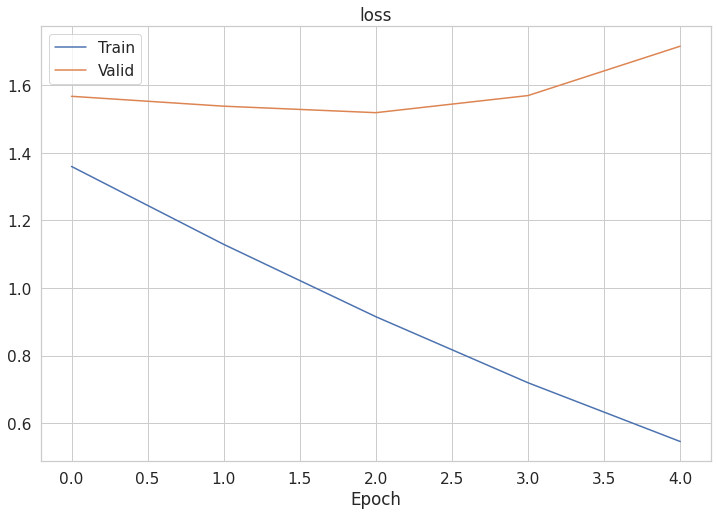

In [140]:
plt.figure(figsize=(12, 8))
plt.plot(np.arange(len(history['train_loss'])), history['train_loss'], label='Train')
plt.plot(np.arange(len(history['val_loss'])), history['val_loss'], label='Valid')
plt.xlabel('Epoch')
plt.title('loss')
plt.legend()
plt.show()

In [ ]:
class LSTMModel(nn.Module):
    def __init__(self, num_classes, embed_size, vocab_size, hidden_size=128, mean=False):
        super().__init__()
        self.mean = mean
        self.n_hidden = hidden_size
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, bidirectional=True, batch_first=True)
        self.cls = nn.Linear(hidden_size * 2, num_classes)

    def forward(self, x):
        x = self.embedding(x)
        lstm_outputs, states = self.lstm(x) #[:, -1, :]
        state = states[-1]
        if self.mean:
            state = torch.mean(lstm_outputs, dim=1)
        else:
            # state.shape = (B, 2, H)
            state = state.permute((1, 0, 2))
            # state.shape = (B, 2*H)
            state = state.reshape(-1, 2*self.n_hidden)

        output = self.cls(state)
        # print(hidden.shape)
        # output = self.ac(hidden)
        return output

    def train_on_batch(self, x, y):
        self.train()
        self.optimizer.zero_grad()
        loss = self._validate(x, y)
        loss["loss"].backward()
        self.optimizer.step()
        return loss

    def validate_on_batch(self, x, y):
        self.eval()
        with torch.no_grad():
            return self._validate(x, y)

    def _validate(self, x, y):
        if self.device is not None:
            y = y.to(self.device)
            x = x.to(self.device)
        prediction = self(x) #   self.forward(x) = self.__call__(x)
        loss = self.criterion(prediction, y)
        labels = prediction.argmax(-1)
        return {"loss": loss, "label": labels}

In [ ]:
def update_metrics(metrics, batch_output, batch_labels):
    n_batches = metrics["n_batches"]
    # Что здесь не так?
    metrics["loss"] = (metrics["loss"] * n_batches + batch_output["loss"].item()) / (n_batches + 1)
    metrics["n_batches"] += 1
    are_equal = (batch_output["label"] == batch_labels).cpu().numpy().astype("int")
    metrics["correct"] += are_equal.sum()
    metrics["total"] += are_equal.shape[0]
    metrics["accuracy"] = metrics["correct"] / max(metrics["total"], 1)

In [ ]:
def do_epoch(model, dataloader, mode="validate", epoch=1):
    metrics = {"correct": 0, "total": 0, "loss": 0.0, "n_batches": 1}

    func = model.train_on_batch if mode == "train" else model.validate_on_batch
    progress_bar = tqdm(dataloader, leave=True)
    progress_bar.set_description(f"{mode}, epoch={epoch}")

    for batch in progress_bar:
        batch_output = func(batch['input'], batch["label"])
        update_metrics(metrics, batch_output, batch["label"])
        progress_bar.set_postfix({"loss": round(metrics["loss"], 4), "acc": round(100 * metrics["accuracy"], 2)})
    return metrics

In [ ]:
train_dataloader = BatchDataLoader(train_dataset, device="cuda", batch_size=30)
test_dataloader = BatchDataLoader(test_dataset, device="cuda", batch_size=30)
NEPOCHS = 5

model = LSTMModel(len(label2idx), embed_size=glove_model.vector_size, vocab_size=len(glove_vocab.vocab)).to(device)

best_val_acc = 0.0
checkpoint = "checkpoint_best.pt"

for epoch in range(NEPOCHS):
    do_epoch(model, train_dataloader, mode="train", epoch=epoch+1)
    epoch_metrics = do_epoch(model, test_dataloader, mode="validate", epoch=epoch+1)

    if epoch_metrics["accuracy"] > best_val_acc:
        best_val_acc = epoch_metrics["accuracy"]
        print(f"Saving checkpoint after epoch {epoch+1}")
        torch.save(model.state_dict(), checkpoint)

model.load_state_dict(torch.load(checkpoint))
do_epoch(model, test_dataloader, mode="validate", epoch="evaluate")


Saving checkpoint after epoch 1


{'accuracy': 0.31128207723844714,
 'correct': 6150,
 'loss': 1.573903871666301,
 'n_batches': 660,
 'total': 19757}

In [ ]:
do_epoch(model, test_dataloader, mode="validate", epoch="evaluate")

Осталось:
1.   Разумные метрики вроде f1
2.   Сделать, чтобы училось, сейчас не учится
3.   С 0/1/2 полносвязными слоями, fastext и bert embendings



In [ ]:
torch.argmax(torch.Tensor([[1, 2], [5, 4]]), axis=1)

tensor([1, 0])